# Plots and Tables Notebook

This notebook produces all of the plots and tables that can be found in out paper. To tun this notebook, it is required that all experiments as defined in the ```run.py```, ```run_clf.py```, and ```run_lequa.py``` script have already been executed, and that  the results from the first two scripts have been preprocessed by the R scripts in the ```process``` folder.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from itertools import product

# autorank package needed for creation of CD plots 
from autorank import autorank, plot_stats, create_report, latex_table
from autorank._util import *

from config import *
from helpers import melt_plotting_dataframe

## Part 0: Preprocessing

Define globale variables and helper functions 

In [2]:
def collect_result_data(mode="binary"):
    
    if mode == "binary":
        datasets = DATASET_INDEX[DATASET_INDEX["classes"] == 2].index
    else:
        datasets = DATASET_INDEX[DATASET_INDEX["classes"] > 2].index
        
    res_files = [os.path.join(PREPROCESSED_RESULTS_PATH,f"{ds_name}_stats_metrics.csv") for ds_name in datasets]
        
    res_df = pd.read_csv(res_files[0])
    res_df["dataset"] = datasets[0]
    val_cols = [col for col in list(res_df) if any([f"{str_qf}_" in col or f"{str_qf}-" in col for str_qf in QUANTIFIER_LIST]) and "Class" not in col]

    
    curr_cols = PROCESSED_RESULTS_KEY_COLUMNS + val_cols
    
    res_df = res_df[curr_cols]
    
    for i in range(1, len(datasets)):
        curr_df = pd.read_csv(res_files[i])
        curr_df["dataset"] = datasets[i]
        val_cols = [col for col in list(curr_df) if any([f"{str_qf}_" in col or f"{str_qf}-" in col for str_qf in QUANTIFIER_LIST]) and "Class" not in col]
        curr_cols = PROCESSED_RESULTS_KEY_COLUMNS + val_cols
        res_df = pd.concat([res_df,curr_df[curr_cols]], join="outer", ignore_index=True)
    
    return res_df

In [3]:
def collect_lequa_result_data(mode="binary"):
    
    res_files = [f for f in os.listdir(LEQUA_RESULT_PATH) if mode in f]
    df_res = pd.concat([pd.read_csv(os.path.join(LEQUA_RESULT_PATH,fname), index_col=0) for fname in res_files], axis=1)
    
    return df_res

In [4]:
main_results_dict = {"binary": collect_result_data("binary"),
                    "multiclass": collect_result_data("multiclass")
                   }
lequa_results_dict = {"binary": collect_lequa_result_data(mode="binary"),
                     "multiclass": collect_lequa_result_data(mode="multiclass")}

In [5]:
quantifier_dict = {
    "main": {"binary": QUANTIFIER_LIST[:-3] + ["QF", "QF-AC"],
             "multiclass": list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX["multiclass"] != "No"].index),
            },
    "clf": {"binary": CLF_QUANTIFIER_LIST,
            "multiclass": list(QUANTIFIER_INDEX.loc[(QUANTIFIER_INDEX["clf_type"] != "none") & (QUANTIFIER_INDEX["multiclass"] != "No")].index)
           },
    "lequa_main":  {"binary": QUANTIFIER_LIST + ["QF-AC"],
                    "multiclass": list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX["multiclass"] != "No"].index)
           },
    "lequa_clf":  {"binary": CLF_QUANTIFIER_LIST,
                   "multiclass": list(QUANTIFIER_INDEX.loc[(QUANTIFIER_INDEX["clf_type"] != "none") & (QUANTIFIER_INDEX["multiclass"] != "No")].index)
           },
    "lequa_opt":  {"binary": QUANTIFIER_LIST,
                   "multiclass": TUNABLE_QUANTIFIER_LIST[:-2] + ["HDx", "ED"]
           }
}

In [6]:
def get_experiment_data(experiment="main", mode="binary"):

    if experiment not in EXPERIMENT_LIST:
        raise ValueError("Invalid experiment!")
    
    if "lequa" in experiment:
        main_df = lequa_results_dict[mode]
        measures = LEQUA_MEASURES
    else:
        main_df = main_results_dict[mode]
        measures = MAIN_EXPERIMENT_MEASURES
        
        if "clf" in experiment:
            main_df = main_df.loc[main_df.dataset.isin(CLF_DATASET_LIST)]

    qf_names = quantifier_dict[experiment][mode][:]
   
    if "clf" in experiment:
        
        qf_clf_names = []
        for str_qf in qf_names:
            clf_list = BASE_CLASSIFIER_DICT[str_qf]

            qf_clf_names += [str_qf] + [f"{str_qf}-{str_clf}" for str_clf in clf_list]

        qf_names = qf_clf_names
        
        if mode == "binary" and experiment == "clf":
             qf_names += ["SVM-K", "SVM-Q", "RBF-K", "RBF-Q"]
                
    elif experiment == "lequa_opt":
        qf_opt_names = []
        
        for str_qf in qf_names:
            qf_opt_names += [str_qf]
            if str_qf in TUNABLE_QUANTIFIER_LIST:
                qf_opt_names += [f"{str_qf}-{TUNED_QUANTIFIER_COLUMN_SUFFIX}"]
                
        qf_names = qf_opt_names

    exp_cols = [f"{str_qf}_{m}" for str_qf, m in product(qf_names, measures)]

    missing_cols = set(exp_cols) - set(list(main_df))
    if len(missing_cols) > 0:
        print(missing_cols)

    if "lequa" not in experiment:
        return main_df.loc[:,PROCESSED_RESULTS_KEY_COLUMNS+exp_cols]

    return main_df.loc[:,exp_cols]

In [7]:
def compute_means_table(experiment="main", 
                        mode="binary", 
                        measure="AE", 
                        cond=None, 
                        fname=None, 
                        save=True,
                        save_latex=False,
                        return_table=False):
    
    if "lequa" in experiment:
        raise ValueError("Wrong experiment!")
        
    res_df = get_experiment_data(experiment=experiment, mode=mode)
    
    if cond is not None:
        res_df = eval(cond)
    
    qf_names = quantifier_dict[experiment][mode][:]

    res_cols = ["dataset"] + [col for col in list(res_df) if f"_{measure}" in col]
    
    means_df = res_df.loc[:,res_cols].groupby("dataset").mean()
    means_df = means_df.rename(lambda s: s.split("_")[0], axis=1)
    
    if save:
        if fname is None:
            fname = f"means_{experiment}_{mode}_{measure}.csv"
        else:
            fname = f"means_{fname}"
        
        means_df.to_csv(os.path.join(RESULT_TABLES_PATH,f"{fname}"))
        
        if save_latex:
            means_table_to_latex(means_df, fname)
        
    if return_table:
        return means_df

In [8]:
def split_clf_tables(mode="binary", measure="AE"):
    
    means_df = compute_means_table(experiment="clf", 
                                   mode=mode, 
                                   measure=measure, 
                                   cond = None,
                                   save=False, 
                                   return_table=True)
    
    qf_dict = dict()
    
    if mode == "binary":
        qf_dict["AC"] = list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX.module_name=="QFY.AC"].index)
        qf_dict["DM"] = list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX.module_name=="QFY.distribution_matching"].index)
        qf_dict["CC"] = list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX.module_name=="QFY.classification_models"].index)
    else:
        qf_dict["OVR"] = list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX.multiclass=="OVR"].index)
        qf_dict["MC"] = list(QUANTIFIER_INDEX.loc[QUANTIFIER_INDEX.multiclass=="Yes"].index)
        
    for key in qf_dict.keys():
        curr_cols = [col for col in list(means_df) if any([col.startswith(str_qf) for str_qf in qf_dict[key]])]
        res_df = means_df.loc[:,curr_cols]
        # res_df.columns = [(f"-{col.split('-')[1]}" if "-" in col else col) for col in curr_cols]
        fname = f"means_clf_{mode}_{key}_{measure}.csv"
        res_df.to_csv(os.path.join(RESULT_TABLES_PATH, f"{fname}"))
        means_table_to_latex(res_df, fname, split_header=True)

In [9]:
def means_table_to_latex(means_df, fname, split_header=False):

    df = means_df.rename(index = DATASET_INDEX.abbr)
    df = pd.concat([df,pd.Series(df.mean(), name="Mean").to_frame().T], axis=0)
    df = df.round(decimals=3)
    rowmins = df.min(axis=1)
    for i in range(len(df)):
        min_ind = np.where(df.iloc[i,:]== rowmins[i])
        for j in min_ind:
            df.iloc[i,j] = "\textbf{" + str("%.3f" % df.iloc[i,j].values[0]) + "}"
            
    if split_header:
        df.columns = [("\makecell{" + col.replace("-","\\\\-") + "}" if "-" in col else col) for col in list(df)]
    
    df.to_latex(os.path.join(RESULT_TABLES_TEX_PATH, f"{fname[:-4]}.tex"), escape=False, column_format = 'l|' + 'c'*df.shape[1])

In [10]:
def boxenplot(experiment="main", 
              mode="binary", 
              measure="AE",
              cond=None,
              ylim=(0,2),
              linthresh=0.01, 
              linscale=0.25, 
              yticks=[0,0.01,0.1,1,2], 
              ylabels=None,
              saved_fig_ymin=0.2,
              fname=None,
              save_means_table=False,
              table_to_latex=False):
    
    res_df = get_experiment_data(experiment=experiment, mode=mode)
    if cond is not None:
        res_df = eval(cond)
    
    plot_df = melt_plotting_dataframe(res_df, measure)
    ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                       palette = PLOTS_COLOR_MAP, 
                       order = plot_df.groupby("alg").median().value.sort_values().index, 
                       data=plot_df)
    
    if ylabels is None:
        ylabels = yticks
    
    ax.set_yscale('symlog', linthresh=linthresh, linscale = linscale)
    ax.set(ylim=ylim, ylabel = measure, xlabel=None)
    plt.xticks(rotation=90)
    plt.yticks(ticks=yticks, labels=ylabels,)
    plt.axhline(linthresh, color = "black", linestyle = '--', lw = 1)
    plt.grid(which='major', axis = 'y')
    plt.gcf().subplots_adjust(bottom=saved_fig_ymin)
    
    if fname is None:
        if "lequa" in experiment:
            fname = f"{experiment}_{mode}_{measure}"
        else:
            fname = f"boxen_{experiment}_{mode}_{measure}"
            
    if "lequa" in experiment:
        plt.savefig(os.path.join(LEQUA_PLOT_PATH, fname))
    else:
        plt.savefig(os.path.join(RESULT_PLOTS_PATH, fname)) 
        
        
    if save_means_table:
        fname=f"{fname.replace('boxen_', '')}.csv"
        compute_means_table(experiment=experiment, 
                            mode=mode, 
                            measure=measure, 
                            cond=cond, 
                            fname=fname, 
                            save_latex=table_to_latex)
        
    plt.plot()

In [11]:
def get_lequa_means_table(experiment="main", mode="binary", measures=LEQUA_MEASURES):
    
    res_df = get_experiment_data(experiment=experiment, mode=mode)
    
    qf_names = list(dict.fromkeys([s.split("_")[0] for s in list(res_df)]))

    str_qf = qf_names[0]
    res_cols = [f"{str_qf}_{m}" for m in measures]
    missing_cols = set(res_cols) - set(list(res_df))
    if len(missing_cols)>0:
        print(missing_cols)
    res_table = res_df.loc[:,res_cols].mean(axis=0).T
    res_table = res_table.rename(lambda s: s.split("_")[1])
    res_table = res_table.to_frame(name=str_qf)
    for str_qf in qf_names[1:]:
        curr_column = res_df.loc[:,[f"{str_qf}_{m}" for m in measures]].mean(axis=0).T
        curr_table = curr_column.rename(lambda s: s.split("_")[1]).to_frame(name=str_qf)
        res_table = pd.concat([res_table, curr_table], axis=1)

    return res_table

## Part 1: Main Experiments


### 1 Plots and Tables for Binary Quantification

In [12]:
sns.set(**PLOTS_SNS_DEFAULT_PARAMS)

#### 1.1 General Results

Plot for AE score:

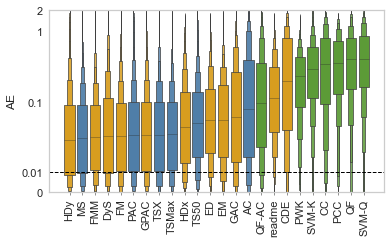

In [13]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True,
          table_to_latex=True
          )

Plot for NKLD Score:

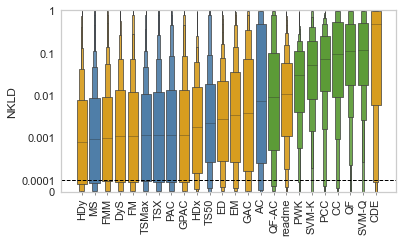

In [14]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="NKLD",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True,
          table_to_latex=True
          )

#### 1.2 Influence of Concept Drift

Plots for AE score:

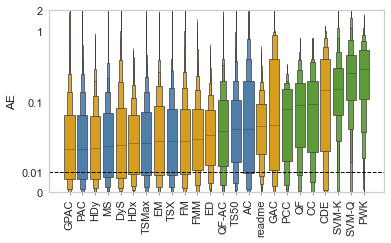

In [15]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="AE",
          cond="res_df[res_df['Drift_MAE'] < 0.2]",
          fname="boxen_binary_AE_lowdrift",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

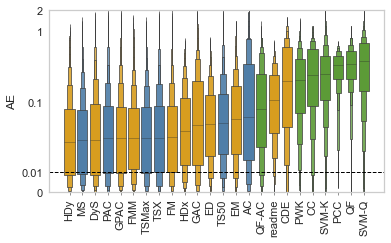

In [16]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="AE",
          cond="res_df[(res_df['Drift_MAE'] >= 0.2) & (res_df['Drift_MAE'] < 0.4)]",
          fname="boxen_binary_AE_meddrift",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

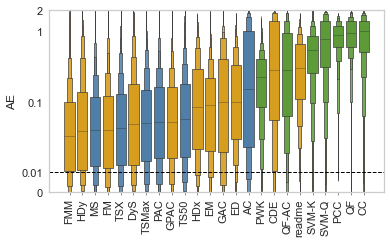

In [17]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="AE",
          cond="res_df[res_df['Drift_MAE'] > 0.4]",
          fname="boxen_binary_AE_highdrift",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

Plots for NKLD score:

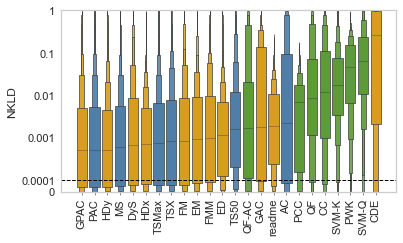

In [18]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="NKLD",
          cond="res_df[res_df['Drift_MAE'] < 0.2]",
          fname="boxen_binary_NKLD_lowdrift",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

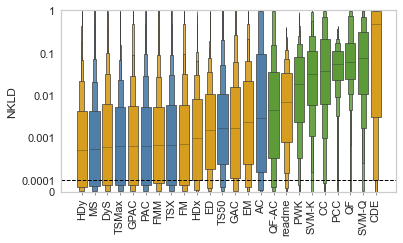

In [19]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="NKLD",
          cond="res_df[(res_df['Drift_MAE'] >= 0.2) & (res_df['Drift_MAE'] < 0.4)]",
          fname="boxen_binary_NKLD_meddrift",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

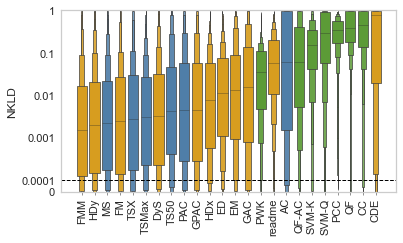

In [20]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="NKLD",
          cond="res_df[res_df['Drift_MAE'] > 0.4]",
          fname="boxen_binary_NKLD_highdrift",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

#### 1.3 Performance under Small Amounts of Training Data

Plot for AE score:

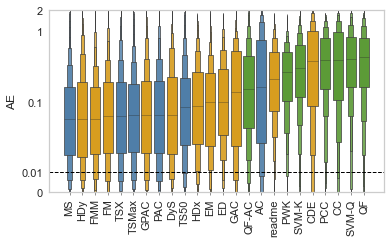

In [21]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="AE",
          cond="res_df[res_df['TT_split'] == '10/90']",
          fname="boxen_binary_AE_fewtrain",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

Plot for NKLD score:

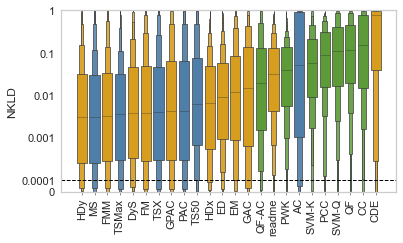

In [22]:
boxenplot(experiment="main", 
          mode="binary", 
          measure="NKLD",
          cond="res_df[res_df['TT_split'] == '10/90']",
          fname="boxen_binary_NKLD_fewtrain",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

### 2 Plots and Tables for Multiclass Quantification

#### 2.1 General Results

Plot for AE score:

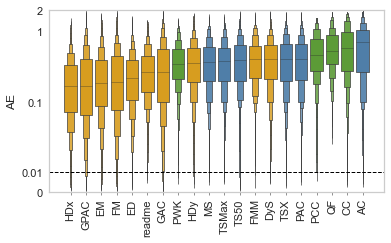

In [23]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True,
          table_to_latex=True
          )

Plot for NKLD score:

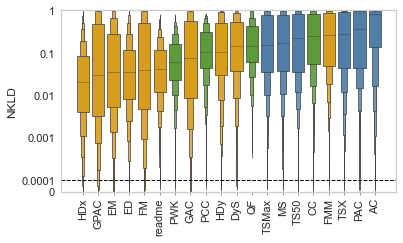

In [24]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="NKLD",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True,
          table_to_latex=True
          )

#### 2.2 Influence of Distribution Shift

Plots for AE score:

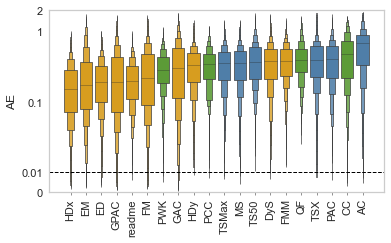

In [25]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="AE",
          cond="res_df[res_df['Drift_MAE'] < 0.25]",
          fname="boxen_multiclass_AE_lowdrift",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

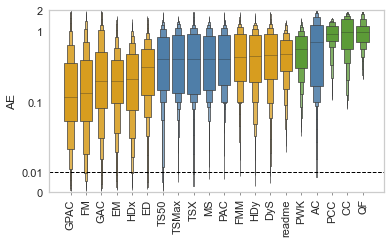

In [26]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="AE",
          cond="res_df[res_df['Drift_MAE'] >= 0.25]",
          fname="boxen_multiclass_AE_highdrift",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

Plots for NKLD score:

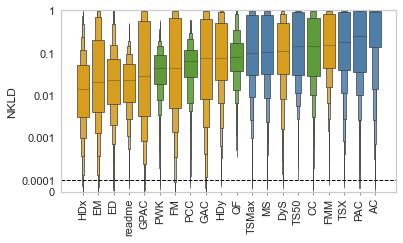

In [27]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="NKLD",
          cond="res_df[res_df['Drift_MAE'] < 0.25]",
          fname="boxen_multiclass_NKLD_lowdrift",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

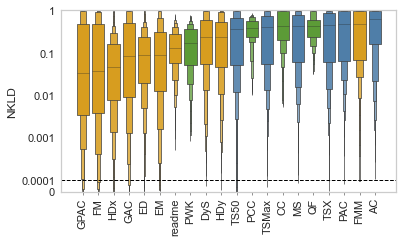

In [28]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="NKLD",
          cond="res_df[res_df['Drift_MAE'] >= 0.25]",
          fname="boxen_multiclass_NKLD_highdrift",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

#### 2.3 Performance under Small Amounts of Training Data

Plot for AE score:

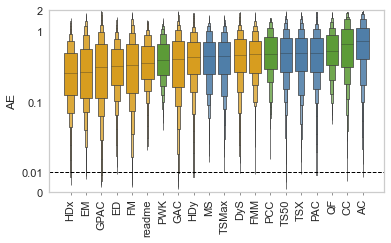

In [29]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="AE",
          cond="res_df[res_df['TT_split'] == '10/90']",
          fname="boxen_multiclass_AE_fewtrain",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          save_means_table=True
          )

Plot for NKLD score:

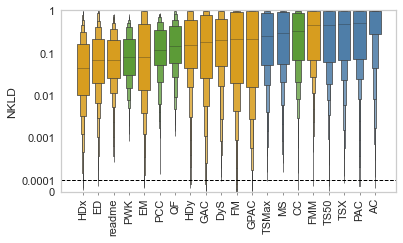

In [30]:
boxenplot(experiment="main", 
          mode="multiclass", 
          measure="NKLD",
          cond="res_df[res_df['TT_split'] == '10/90']",
          fname="boxen_multiclass_NKLD_fewtrain",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01, 0.1,1],
          save_means_table=True
          )

### 3 Plots and Tables for Quantification with Tuned Classifiers

In [32]:
## reset plotting parameters for bigger plots
sns.set(**PLOTS_SNS_BROAD_PLOT_PARAMS)

#### 3.1 Results on Binary Datasets

Plot for AE score:

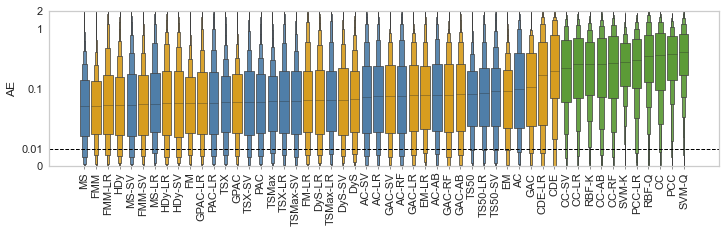

In [33]:
boxenplot(experiment="clf", 
          mode="binary", 
          measure="AE",
          fname="boxen_clf_binary_AE",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          saved_fig_ymin = 0.3,
          save_means_table=True
          )

In [33]:
split_clf_tables(mode="binary", measure="AE")

Plot for NKLD score:

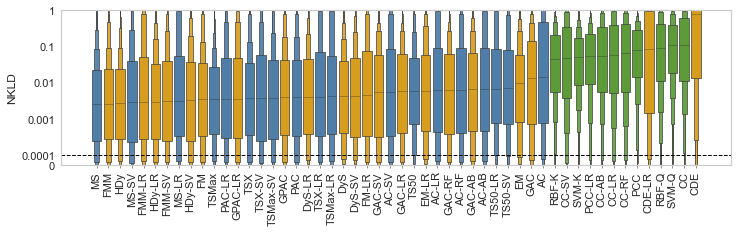

In [34]:
boxenplot(experiment="clf", 
          mode="binary", 
          measure="NKLD",
          fname="boxen_clf_binary_NKLD",
          ylim=(0,1.02),
          linthresh=0.0001, 
          linscale=0.25, 
          yticks = [0,0.0001,0.001,0.01,0.1,1],
          saved_fig_ymin = 0.3,
          save_means_table=True
          )

In [35]:
split_clf_tables(mode="binary", measure="NKLD")

#### 3.2 Results on Multiclass Data

Plots for AE score:

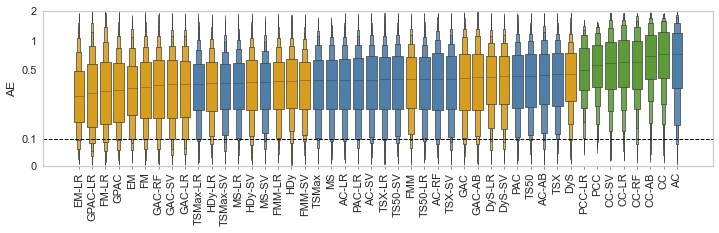

In [36]:
boxenplot(experiment="clf", 
          mode="multiclass", 
          measure="AE",
          fname="boxen_clf_multiclass_AE",
          ylim=(0,2),
          linthresh=0.1, 
          linscale=0.25, 
          yticks = [0, 0.1, 0.5, 1, 2],
          saved_fig_ymin = 0.3,
          save_means_table=True
          )

In [37]:
split_clf_tables(mode="multiclass", measure="AE")

Plot for NKLD score:

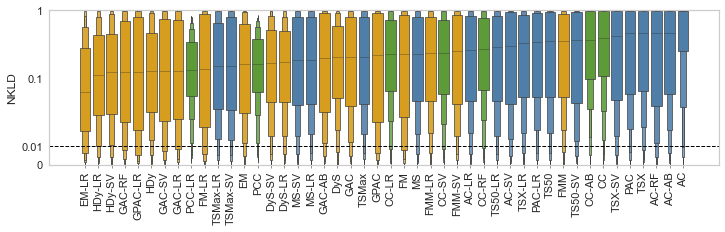

In [38]:
boxenplot(experiment="clf", 
          mode="multiclass", 
          measure="NKLD",
          fname="boxen_clf_multiclass_NKLD",
          ylim=(0,1.02),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1],
          saved_fig_ymin = 0.3,
          save_means_table=True
          )

In [39]:
split_clf_tables(mode="multiclass", measure="NKLD")

### 3 CD Plots

CD Plots are created based on tables of average performances of each algorithm per dataset, which have been generated as a side product along the previously shown plots.

In [40]:
# reset to regular breadth plots
sns.set(**PLOTS_SNS_CD_PLOT_PARAMS)

In [41]:
for f in os.listdir(RESULT_TABLES_PATH):
    if f.endswith(".csv") and "clf" not in f:
        df = pd.read_csv(os.path.join(RESULT_TABLES_PATH, f"{f}"), index_col = 0)
        
        # need to hack into autorank to plot CDs for Multiclass, as by default, 
        # autorank would use other test than friedman-nemenyi
        if "multiclass" in f:
            alpha = 0.05
            alpha_normality = alpha / len(df.columns)
            pval_homogeneity = stats.levene(*df.transpose().values).pvalue
            all_normal, pvals_shapiro = test_normality(df, alpha_normality, verbose=False)
            all_normal=False
            homogeneity_test = 'levene'
            var_equal = pval_homogeneity >= alpha
            res = rank_multiple_nonparametric(df, alpha=0.05, verbose=False, order="ascending", all_normal=False, effect_size=None)
            result = RankResult(res.rankdf, res.pvalue, res.cd, res.omnibus, res.posthoc, all_normal, pvals_shapiro,
                          var_equal, pval_homogeneity, homogeneity_test, alpha, alpha_normality, len(df), None, None,
                          None, None, res.effect_size)
            cd_diagram(result, False, None, PLOTS_CD_WIDTH)
            fig = plt.gcf()
            fig.set_size_inches(PLOTS_CD_WIDTH, PLOTS_CD_HEIGHT)
            plt.savefig(os.path.join(RESULT_PLOTS_PATH, f"CD_{f[6:-4]}.png"))
            plt.close()
            
        elif "binary" in f:
            result = autorank(-df, alpha=0.05, verbose=False)
            cd_diagram(result, False, None, PLOTS_CD_WIDTH)
            fig = plt.gcf()
            fig.set_size_inches(PLOTS_CD_WIDTH, PLOTS_CD_HEIGHT)
            plt.savefig(os.path.join(RESULT_PLOTS_PATH, f"CD_{f[6:-4]}.png"))
            plt.close()

## Part 2: Case Study on LeQua Data

### Experiment 1: Applying Quantifiers Using Their Default Parameters

#### 1.1 Results for the binary data

In [42]:
sns.set(**PLOTS_SNS_DEFAULT_PARAMS)

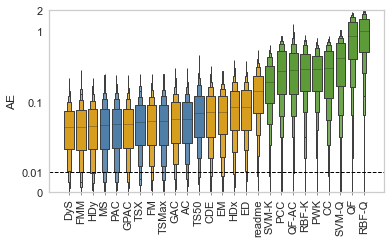

In [43]:
boxenplot(experiment="lequa_main", 
          mode="binary", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2]
          )

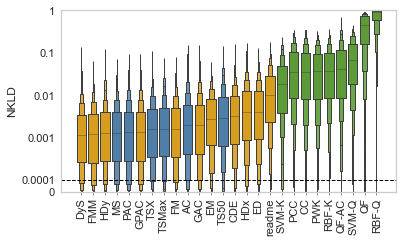

In [44]:
boxenplot(experiment="lequa_main", 
          mode="binary", 
          measure="NKLD", 
          ylim=(0,1.05),
          linthresh=1e-04, 
          linscale=0.25, 
          yticks = [0,1e-04,1e-03,1e-02,1e-01,1]
          )

#### 1.2 Results on multiclass data

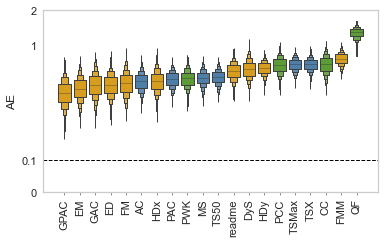

In [45]:
boxenplot(experiment="lequa_main", 
          mode="multiclass", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.1, 
          linscale=0.25, 
          yticks = [0,0.1,1,2]
          )

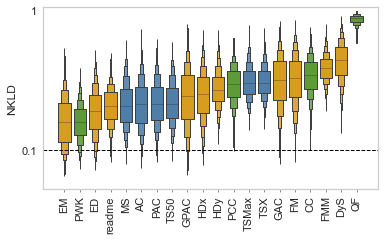

In [46]:
boxenplot(experiment="lequa_main", 
          mode="multiclass", 
          measure="NKLD", 
          ylim=(0,1.05),
          linthresh=1e-01, 
          linscale=0.25, 
          yticks = [1e-01,1]
          )

### Experiment 2: Applying Quantifiers With Tuned Base Classifiers

In [47]:
sns.set(**PLOTS_SNS_BROAD_PLOT_PARAMS)

#### 2.1 Results on binary data

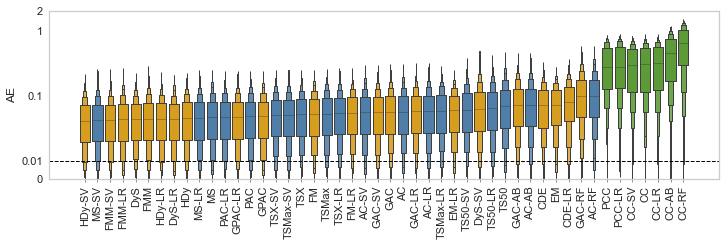

In [48]:
boxenplot(experiment="lequa_clf", 
          mode="binary", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          saved_fig_ymin = 0.25
          )

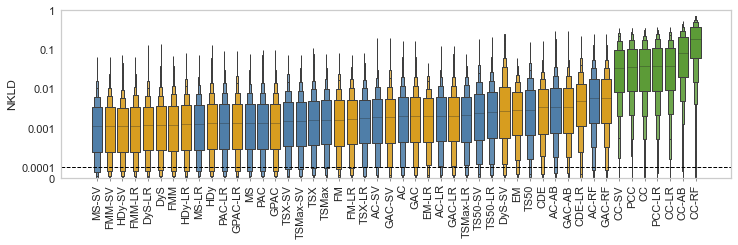

In [49]:
boxenplot(experiment="lequa_clf", 
          mode="binary", 
          measure="NKLD", 
          ylim=(0,1.05),
          linthresh=1e-04, 
          linscale=0.25, 
          yticks = [0,1e-04,1e-03,1e-02,1e-01,1],
          saved_fig_ymin = 0.25
          )

#### 2.2 Results on multiclass data

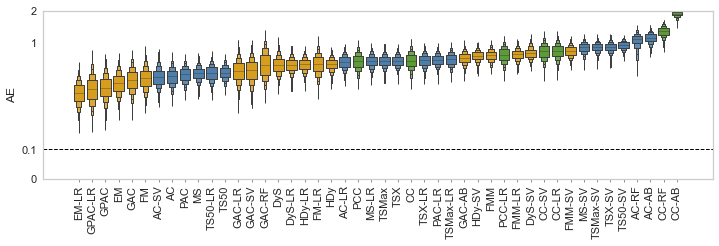

In [50]:
boxenplot(experiment="lequa_clf", 
          mode="multiclass", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.1, 
          linscale=0.25, 
          yticks = [0,0.1,1,2],
          saved_fig_ymin = 0.25
          )

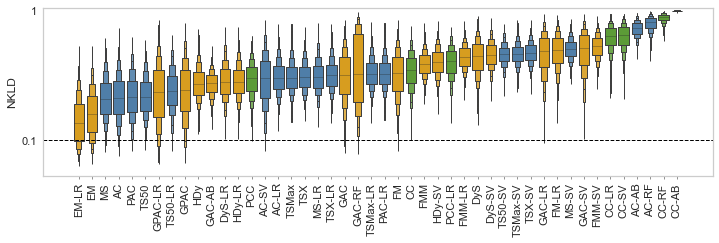

In [51]:
boxenplot(experiment="lequa_clf", 
          mode="multiclass", 
          measure="NKLD", 
          ylim=(0,1.05),
          linthresh=1e-01, 
          linscale=0.25, 
          yticks = [1e-01,1],
          saved_fig_ymin = 0.25
          )

### Experiment 3: Applying Tuned Quantifiers

#### 3.1 Results on binary data

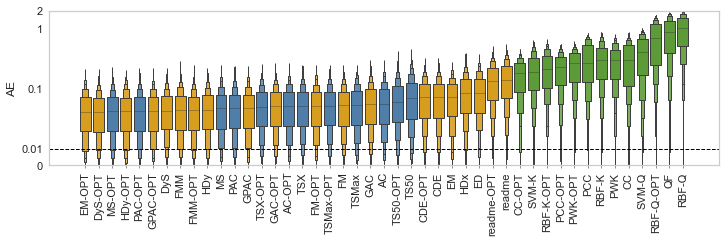

In [52]:
boxenplot(experiment="lequa_opt", 
          mode="binary", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.01, 
          linscale=0.25, 
          yticks = [0,0.01,0.1,1,2],
          saved_fig_ymin = 0.3
          )

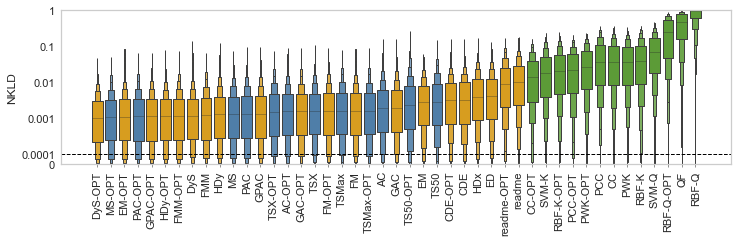

In [53]:
boxenplot(experiment="lequa_opt", 
          mode="binary", 
          measure="NKLD", 
          ylim=(0,1.05),
          linthresh=1e-04, 
          linscale=0.25, 
          yticks = [0,1e-04,1e-03,1e-02,1e-01,1],
          saved_fig_ymin = 0.3
          )

In [54]:
get_lequa_means_table("lequa_opt", "binary").loc[:,["EM-OPT", "DyS-OPT", "MS-OPT", "PAC-OPT", "GPAC-OPT", "HDy"]]

,EM-OPT,DyS-OPT,MS-OPT,PAC-OPT,GPAC-OPT,HDy
AE,0.049870,0.048596,0.050193,0.050928,0.050928,0.053694
RAE,0.109098,0.132494,0.153376,0.156421,0.156421,0.119100
NKLD,0.003208,0.002610,0.002963,0.003211,0.003211,0.004212


#### 3.2 Results on multiclass data

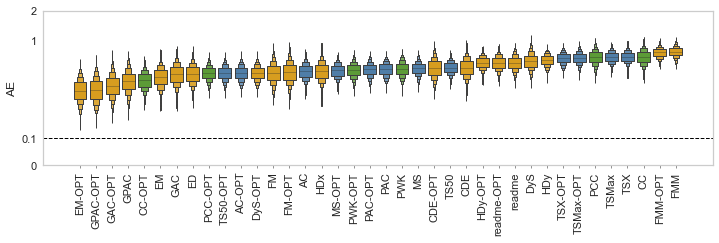

In [55]:
boxenplot(experiment="lequa_opt", 
          mode="multiclass", 
          measure="AE",
          ylim=(0,2),
          linthresh=0.1, 
          linscale=0.25, 
          yticks = [0,0.1,1,2],
          saved_fig_ymin = 0.3
          )

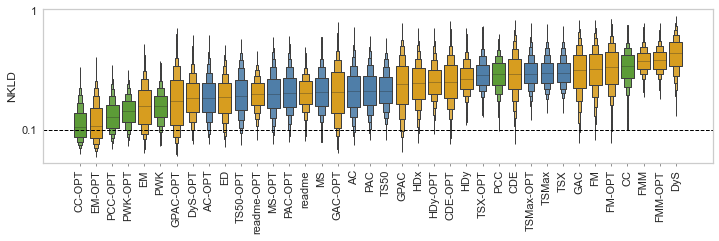

In [56]:
boxenplot(experiment="lequa_opt", 
          mode="multiclass", 
          measure="NKLD", 
          ylim=(0,1.05),
          linthresh=1e-01, 
          linscale=0.25, 
          yticks=[1e-01,1],
          saved_fig_ymin = 0.3
          )

In [57]:
get_lequa_means_table("lequa_opt", "multiclass").loc[:,["EM-OPT", "GPAC-OPT", "HDy-OPT", "GAC-OPT", "GPAC", "EM"]]

,EM-OPT,GPAC-OPT,HDy-OPT,GAC-OPT,GPAC,EM
AE,0.316935,0.322383,0.593675,0.352448,0.392343,0.427035
RAE,0.966455,0.864474,2.305028,1.003078,1.085117,1.493077
NKLD,0.121333,0.200593,0.272427,0.236063,0.268286,0.173723
